In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def displayMatrixCorr(df, val_manquante = None, bigSize = False):
    # Filtrer les colonnes ayant moins de 400 valeurs manquantes
    if val_manquante == None :
        corr_matrix = df.corr()
    else :
        filtered_df = df.loc[:, df.isnull().sum() < val_manquante]
    
        # Calculer la matrice de corrélation
        corr_matrix = filtered_df.corr()
    
    # Afficher la matrice de corrélation
    if bigSize :
        plt.figure(figsize=(24, 20))
    else :
        plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title("Matrice de corrélation")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


script_dir = Path.cwd() 

df = pd.read_csv(script_dir.parent / '4 - Dataset' / "regression_weld_data_noOutliers.csv")

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1324 non-null   float64
 1   Silicon concentration (weight%)               1324 non-null   float64
 2   Manganese concentration (weight%)             1324 non-null   float64
 3   Sulphur concentration (weight%)               1324 non-null   float64
 4   Phosphorus concentration (weight%)            1324 non-null   float64
 5   Oxygen concentration (%)                      1324 non-null   float64
 6   Nitrogen concentration (%)                    1324 non-null   float64
 7   Current (A)                                   1324 non-null   float64
 8   Voltage (V)                                   1324 non-null   float64
 9   Heat input (kJ/mm)                            1324 non-null   f

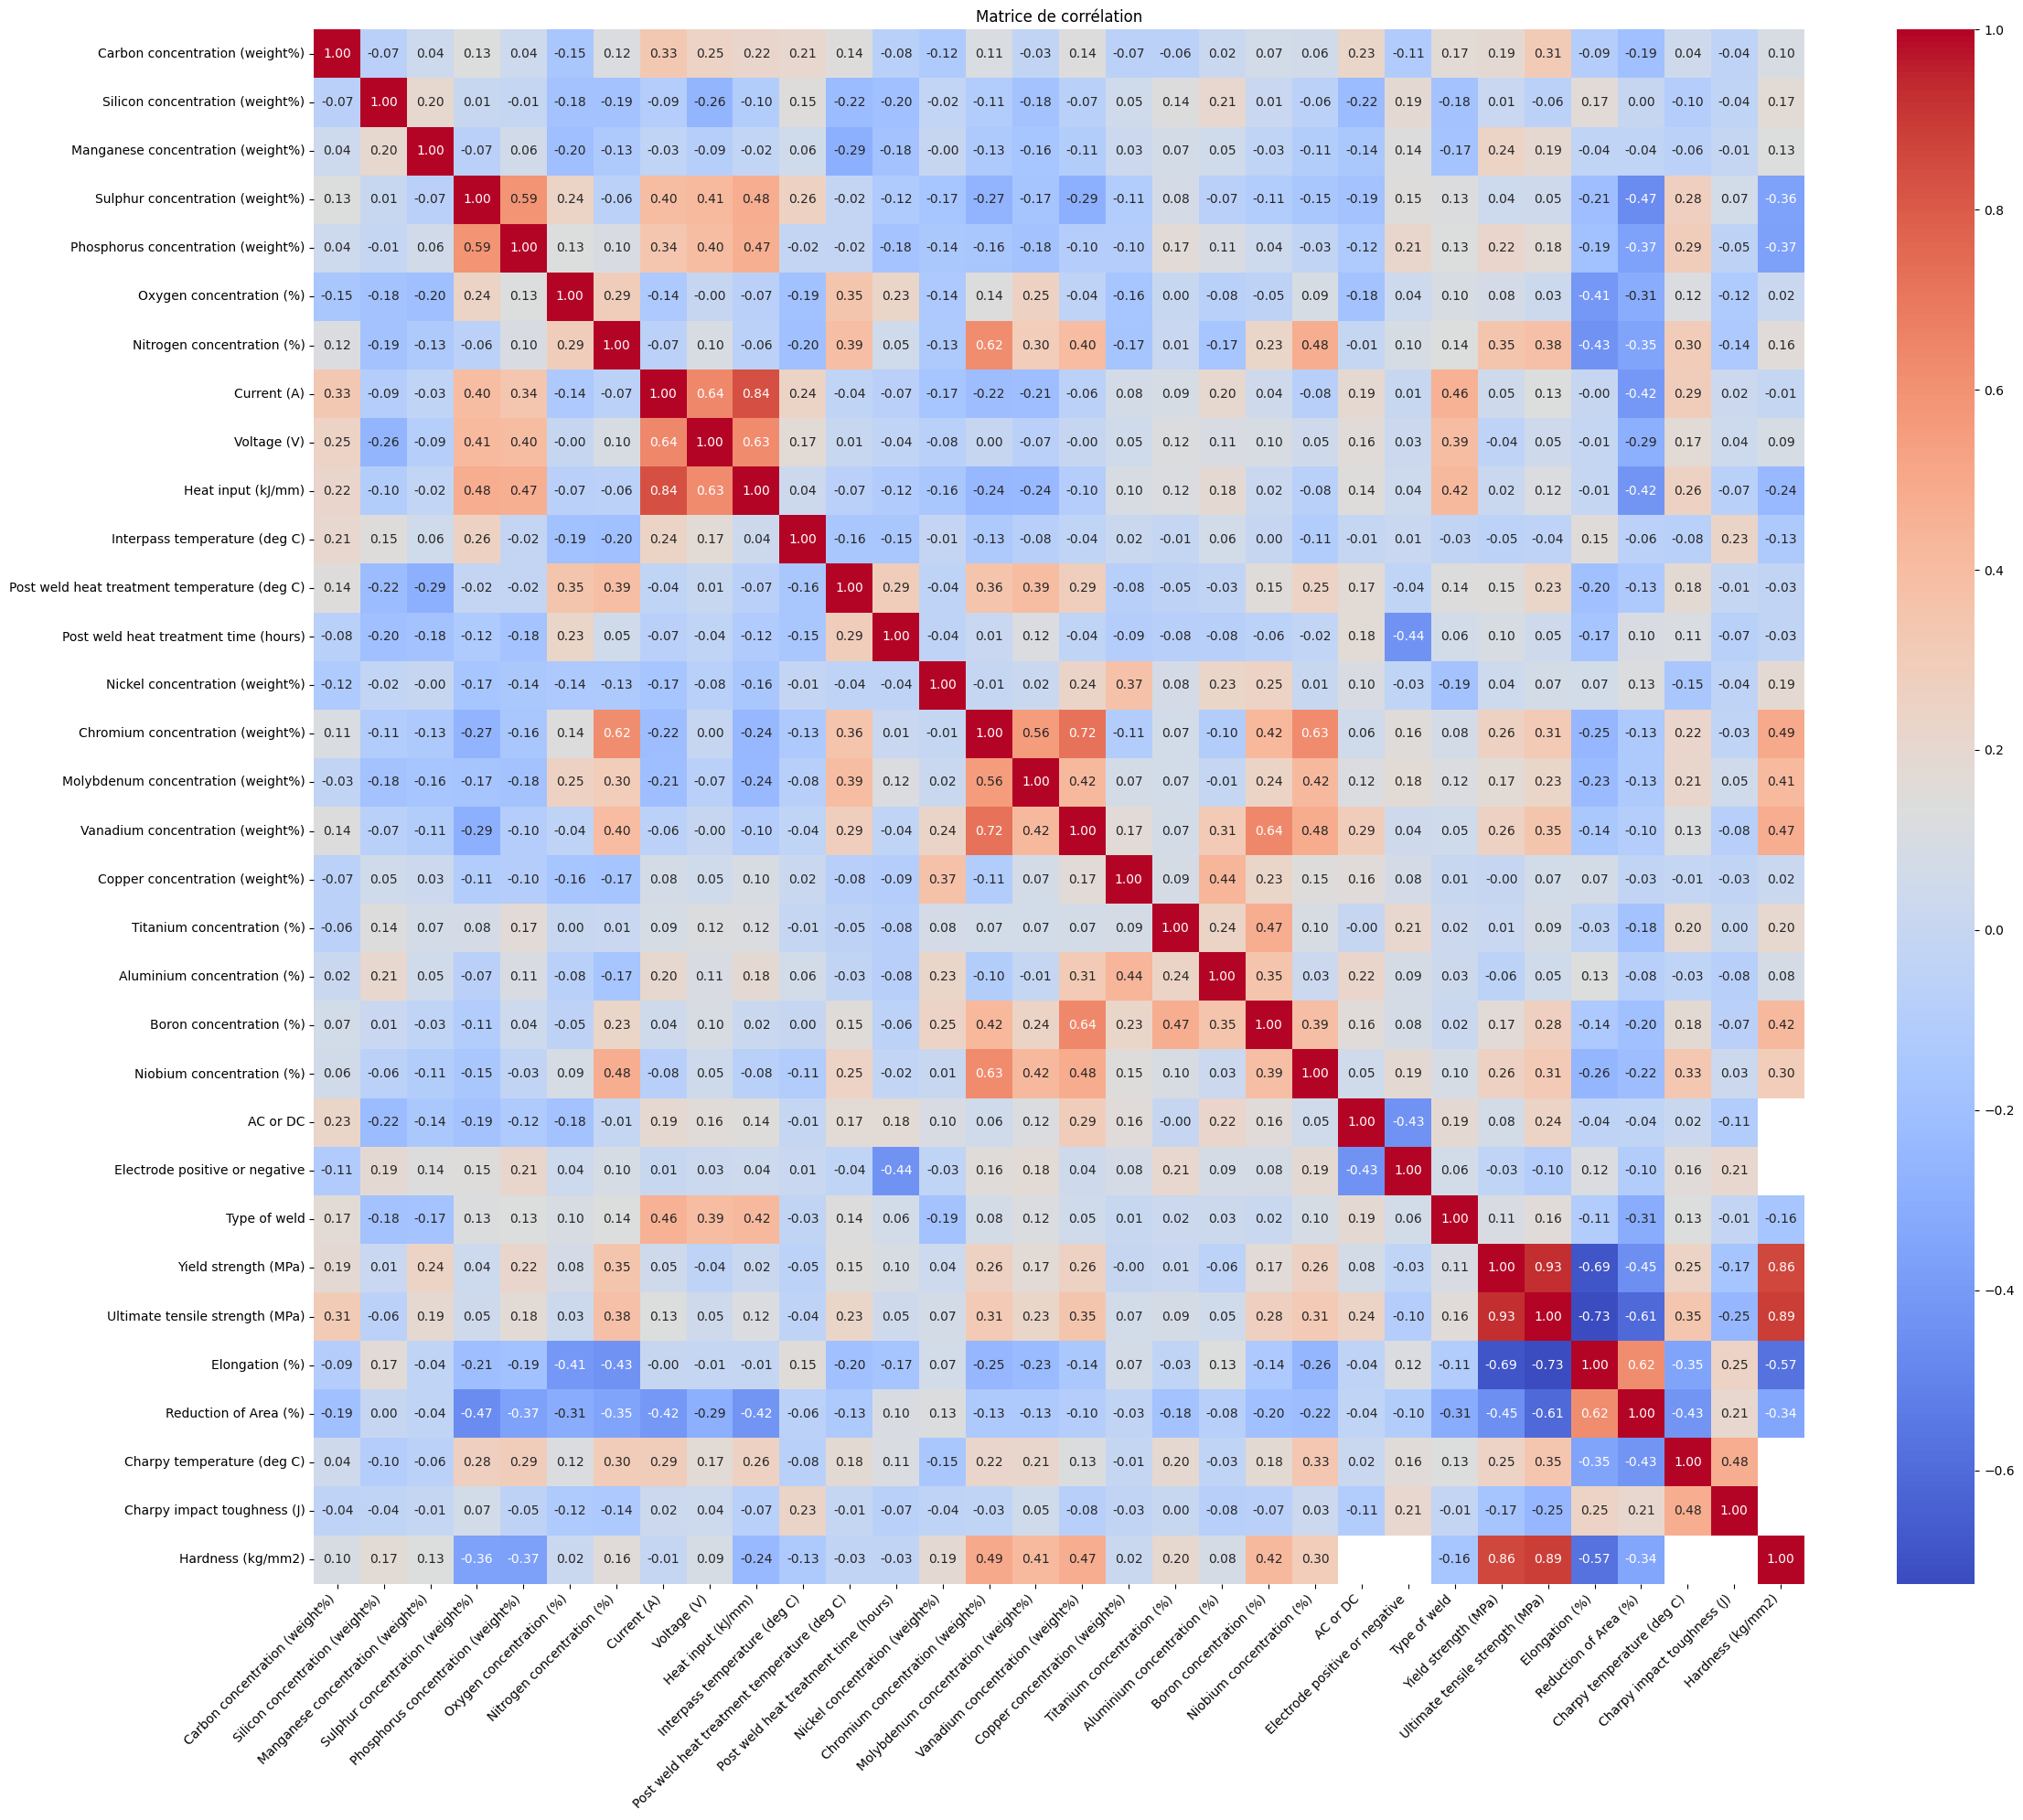

In [67]:
displayMatrixCorr(df, bigSize = True)

In [68]:
df = df.drop(['Current (A)', 'Hardness (kg/mm2)'], axis=1)

In [69]:
L_targets = [ 'Yield strength (MPa)',
    'Ultimate tensile strength (MPa)', 'Elongation (%)',
    'Reduction of Area (%)', 'Charpy impact toughness (J)', 'Charpy temperature (deg C)'
] #'Charpy impact toughness (J)', 'Charpy temperature (deg C)'

ys = df[L_targets]
print(ys.shape) 
ys = ys.drop_duplicates() 
print(ys.shape)

ys_noNaN = ys.dropna()
print(ys_noNaN.shape)

(1324, 6)
(1110, 6)
(423, 6)


# gestion des outliers

In [70]:
def get_outlier_indices(df, coeff = 1.5):
    # Initialiser un dictionnaire pour stocker les indices des lignes à supprimer
    outlier_indices = {}
    no_outlier_feature = []

    # Parcourir chaque colonne numérique du DataFrame
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculer les quartiles Q1 (25e percentile) et Q3 (75e percentile)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calculer l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Définir les bornes pour identifier les outliers
        lower_bound = Q1 - coeff * IQR
        upper_bound = Q3 + coeff * IQR
        
        # Trouver les indices des lignes où la valeur est un outlier
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
        
        # Si des outliers sont trouvés, les ajouter au dictionnaire
        if outliers:
            outlier_indices[col] = outliers
        else :
            no_outlier_feature.append(col)

    return outlier_indices , no_outlier_feature

dico_indice_outliers_IQR, no_outlier_feature = get_outlier_indices(ys_noNaN,1.5)
#print(len(dico_indice_outliers))
print(no_outlier_feature)


valeurs_uniques = set()
for cle, valeur in dico_indice_outliers_IQR.items():
    valeurs_uniques.update(valeur)
    # Vérifier que la valeur est une liste
    if isinstance(valeur, list):
        # Afficher la clé et la longueur de la liste
        print(f"Clé : {cle}, Longueur de la liste : {len(valeur)}")

print("Valeurs uniques :", valeurs_uniques)
print("longeur :" , len(valeurs_uniques))

['Elongation (%)']
Clé : Yield strength (MPa), Longueur de la liste : 2
Clé : Ultimate tensile strength (MPa), Longueur de la liste : 4
Clé : Reduction of Area (%), Longueur de la liste : 29
Clé : Charpy impact toughness (J), Longueur de la liste : 19
Clé : Charpy temperature (deg C), Longueur de la liste : 3
Valeurs uniques : {780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 405, 406, 411, 412, 1311, 1312, 417, 418, 423, 424, 429, 48, 434, 435, 440, 441, 453, 1093, 1094, 1095, 459, 465, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1138}
longeur : 51


In [87]:
ys_noOutliers = ys_noNaN.drop(valeurs_uniques)
ys_noOutliers = ys_noOutliers.sample(frac=1, random_state=42)
ys_noOutliers = ys_noOutliers.iloc[:50,:]
print(ys_noOutliers.shape)
print(ys_noOutliers.info())

(50, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 1268 to 208
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Yield strength (MPa)             50 non-null     float64
 1   Ultimate tensile strength (MPa)  50 non-null     float64
 2   Elongation (%)                   50 non-null     float64
 3   Reduction of Area (%)            50 non-null     float64
 4   Charpy impact toughness (J)      50 non-null     float64
 5   Charpy temperature (deg C)       50 non-null     float64
dtypes: float64(6)
memory usage: 2.7 KB
None


# Clustering

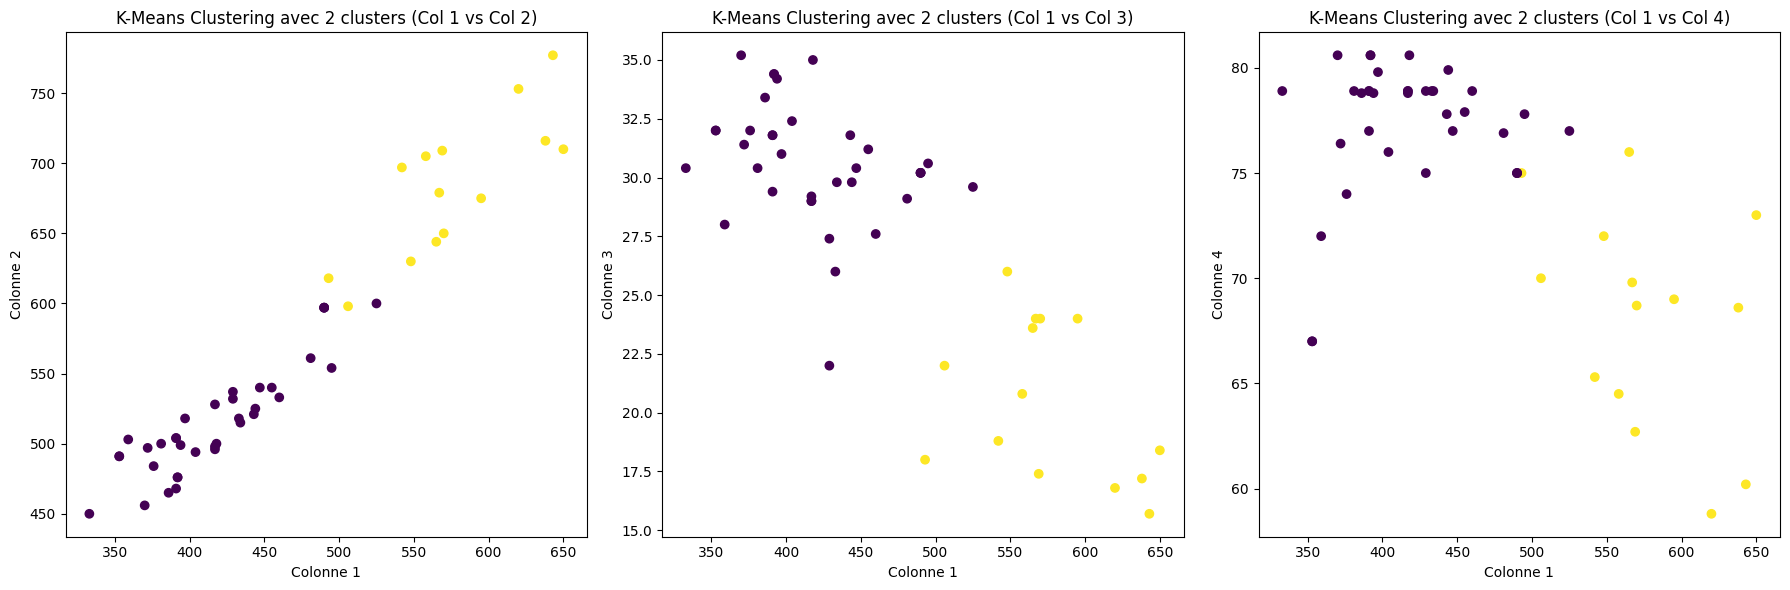

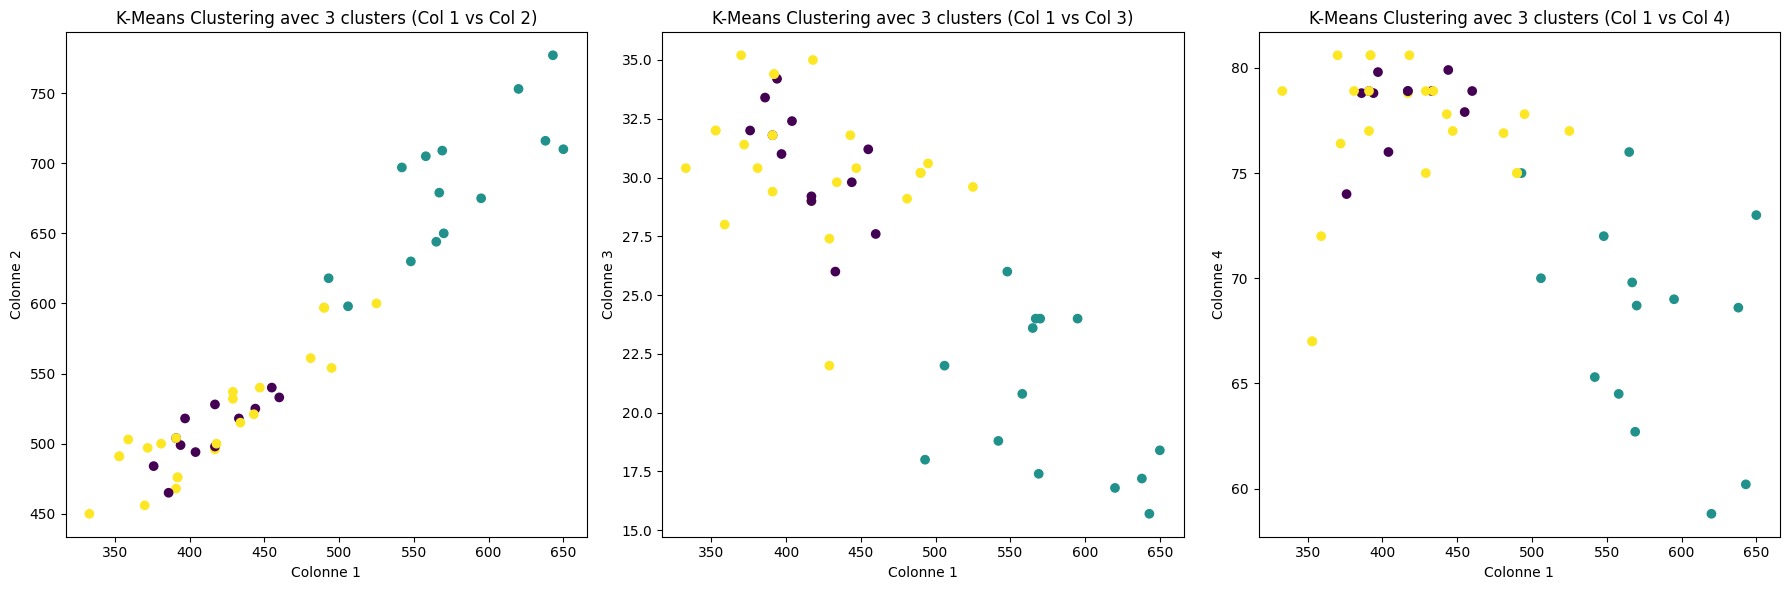

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Fonction K-Means avec visualisation 2D et 3D
def k_means_clustering_visualize(ys1, n_clusters=3, plot_3d=True):
    """
    Applique K-Means sur un dataset et affiche les clusters en 2D ou 3D.
    
    Paramètres:
    ys : DataFrame pandas, contenant 4 colonnes de données
    n_clusters : nombre de clusters à former
    plot_3d : booléen, si True affiche le graphique en 3D, sinon en 2D
    
    Retourne:
    Un DataFrame avec les labels des clusters ajoutés et les graphiques.
    """
    ys = ys1.copy()
    # Standardisation des données (important pour K-Means si les échelles sont différentes)
    scaler = StandardScaler()
    ys_scaled = scaler.fit_transform(ys)
    
    # Application du clustering K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    ys['cluster'] = kmeans.fit_predict(ys_scaled)
    
    # Affichage des résultats
    if plot_3d:
        # Visualisation en 3D
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(ys.iloc[:, 0], ys.iloc[:, 1], ys.iloc[:, 2], c=ys['cluster'], cmap='viridis', marker='o')
        
        ax.set_xlabel('Colonne 1')
        ax.set_ylabel('Colonne 2')
        ax.set_zlabel('Colonne 3')
        plt.title(f'K-Means Clustering (3D) avec {n_clusters} clusters')
        plt.show()
    
    else:
        # Visualisation en 2D avec trois graphiques sur la même ligne
        plt.figure(figsize=(18, 6))  # Taille de la figure ajustée pour bien espacer les graphes

        # Premier graphique : colonne 1 en X, colonne 2 en Y
        plt.subplot(1, 3, 1)  # 1 ligne, 3 colonnes, 1er graphique
        plt.scatter(ys.iloc[:, 0], ys.iloc[:, 1], c=ys['cluster'], cmap='viridis', marker='o')
        plt.xlabel('Colonne 1')
        plt.ylabel('Colonne 2')
        plt.title(f'K-Means Clustering avec {n_clusters} clusters (Col 1 vs Col 2)')

        # Deuxième graphique : colonne 1 en X, colonne 3 en Y
        plt.subplot(1, 3, 2)  # 1 ligne, 3 colonnes, 2ème graphique
        plt.scatter(ys.iloc[:, 0], ys.iloc[:, 2], c=ys['cluster'], cmap='viridis', marker='o')
        plt.xlabel('Colonne 1')
        plt.ylabel('Colonne 3')
        plt.title(f'K-Means Clustering avec {n_clusters} clusters (Col 1 vs Col 3)')

        # Troisième graphique : colonne 1 en X, colonne 4 en Y
        plt.subplot(1, 3, 3)  # 1 ligne, 3 colonnes, 3ème graphique
        plt.scatter(ys.iloc[:, 0], ys.iloc[:, 3], c=ys['cluster'], cmap='viridis', marker='o')
        plt.xlabel('Colonne 1')
        plt.ylabel('Colonne 4')
        plt.title(f'K-Means Clustering avec {n_clusters} clusters (Col 1 vs Col 4)')

        # Ajustement de l'espacement entre les graphiques pour qu'ils ne se chevauchent pas
        plt.tight_layout()

        # Affichage des trois graphiques
        plt.show()
    
    return ys

result_df_3 = k_means_clustering_visualize(ys_noOutliers, n_clusters=2, plot_3d=False)
result_df_4 = k_means_clustering_visualize(ys_noOutliers, n_clusters=3, plot_3d=False)

In [89]:
def generate_cluster_datasets_and_stats(df, cluster_column='cluster'):
    """
    Sépare un DataFrame en n datasets basés sur le cluster et affiche les statistiques pour chaque cluster.
    
    Paramètres :
    df : DataFrame pandas contenant les données avec une colonne de cluster
    cluster_column : le nom de la colonne contenant les labels de cluster (par défaut 'cluster')
    
    Retourne :
    Une liste de DataFrames, chacun contenant les données d'un cluster, ainsi que les statistiques affichées pour chaque cluster.
    """
    # Initialiser une liste pour stocker les datasets par cluster
    cluster_datasets = []
    
    # Obtenir la liste des clusters uniques
    clusters = df[cluster_column].unique()
    
    # Boucler sur chaque cluster et calculer les statistiques
    for cluster in clusters:
        # Filtrer les lignes appartenant à ce cluster
        cluster_data = df[df[cluster_column] == cluster]
        
        # Ajouter ce dataset à la liste
        cluster_datasets.append(cluster_data)
        
        # Calculer les statistiques : moyenne, variance, écart-type, médiane pour chaque colonne
        stats = cluster_data.describe().T[['mean', '50%', 'std']]  # "50%" correspond à la médiane dans pandas
        stats['variance'] = cluster_data.var()

        # Afficher les statistiques pour ce cluster
        print(f"\nStatistiques pour le Cluster {cluster}:")
        print(stats[['mean', 'std', 'variance', '50%']])
    
    return cluster_datasets



cluster_datasets = generate_cluster_datasets_and_stats(result_df_3)



Statistiques pour le Cluster 1:
                                       mean        std     variance     50%
Yield strength (MPa)             576.000000  48.394215  2342.000000  568.00
Ultimate tensile strength (MPa)  682.928571  51.034625  2604.532967  688.00
Elongation (%)                    20.478571   3.393700    11.517198   19.80
Reduction of Area (%)             68.114286   5.233157    27.385934   68.85
Charpy impact toughness (J)       70.500000  44.571032  1986.576923   85.00
Charpy temperature (deg C)       -11.785714  31.476923   990.796703   -4.00
cluster                            1.000000   0.000000     0.000000    1.00

Statistiques pour le Cluster 0:
                                       mean        std     variance    50%
Yield strength (MPa)             418.027778  46.409658  2153.856349  417.0
Ultimate tensile strength (MPa)  515.694444  39.193162  1536.103968  504.0
Elongation (%)                    30.619444   2.616193     6.844468   30.4
Reduction of Area (%)     

In [90]:
target = result_df_3['cluster']
target.head()

1268    1
164     1
145     1
1253    0
247     0
Name: cluster, dtype: int32

In [91]:
# Reindexer le DataFrame pour l'aligner avec l'index de df
df_reindexed = target.reindex(df.index)

# Remplacer les NaN par -1 pour les indices sans valeurs dans 'cluster'
df_reindexed.fillna(-1, inplace=True)

# Ajouter la colonne 'cluster' au DataFrame df
df['cluster'] = df_reindexed.astype(int)

# Afficher le DataFrame final
(df.head())    

,Carbon concentration (weight%),Silicon concentration (weight%),Manganese concentration (weight%),Sulphur concentration (weight%),Phosphorus concentration (weight%),Oxygen concentration (%),Nitrogen concentration (%),Voltage (V),Heat input (kJ/mm),Interpass temperature (deg C),...,AC or DC,Electrode positive or negative,Type of weld,Yield strength (MPa),Ultimate tensile strength (MPa),Elongation (%),Reduction of Area (%),Charpy temperature (deg C),Charpy impact toughness (J),cluster
0,0.037,0.30,0.65,0.008,0.012,0.0421,0.0082,21.0,1.0,200.0,...,0.0,1.0,0.0,392.0,466.0,31.9,80.6,NaN,NaN,-1
1,0.037,0.30,0.65,0.008,0.012,0.0421,0.0082,21.0,1.0,200.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,-28.0,100.0,-1
2,0.037,0.30,0.65,0.008,0.012,0.0421,0.0082,21.0,1.0,200.0,...,0.0,1.0,0.0,370.0,456.0,35.2,80.6,-38.0,100.0,0
3,0.037,0.31,1.03,0.007,0.014,0.0421,0.0082,21.0,1.0,200.0,...,0.0,1.0,0.0,413.0,498.0,31.2,80.6,NaN,NaN,-1
4,0.037,0.31,1.03,0.007,0.014,0.0421,0.0082,21.0,1.0,200.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,-48.0,100.0,-1


In [92]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df)
df_final = pd.DataFrame(df_imputed , columns=df.columns)
df_final.rename(columns={'cluster': 'target'}, inplace=True)
df_final['target'] = df_final['target'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Carbon concentration (weight%)                1324 non-null   float64
 1   Silicon concentration (weight%)               1324 non-null   float64
 2   Manganese concentration (weight%)             1324 non-null   float64
 3   Sulphur concentration (weight%)               1324 non-null   float64
 4   Phosphorus concentration (weight%)            1324 non-null   float64
 5   Oxygen concentration (%)                      1324 non-null   float64
 6   Nitrogen concentration (%)                    1324 non-null   float64
 7   Voltage (V)                                   1324 non-null   float64
 8   Heat input (kJ/mm)                            1324 non-null   float64
 9   Interpass temperature (deg C)                 1324 non-null   f

In [93]:
df_final.to_csv('../4 - Dataset/semi-dataset.csv', index=False)